**Для ревьеров:**
Критерии оценки:

- "Отлично"
  - Исследовательский анализ данных дает четкое представление о структуре данных
  - Присутствуют поясняющие комментарии к коду
  - Хорошее качество кода

- "Можно лучше"
  - Исследовательский анализ данных дает хорошее представление о структуре данных, однако не хватает некоторых визуализаций или статистик
  - Статистический тест выполнен правильно
  - Слишком краткие пояснения и выводы в ячейках `Markdown`
  - Нет комментариев к коду
  - Плохо читаемый код

- "Нужно исправить"
    - Нечеткий EDA, нелогичные визуалзиации, нет вывода о структуре данных
    - Выбран неправильный статистический тест или сам тест выполнен неверно
    - Нет аргументированного вывода о выборе конкретной uplift модели
    - Неправильно разделена выборка на обучающую и тестовую
    - Обучены не все модели
    - Расчет метрик отсутствует или рассчитаны неверно
    - Отсутствует код для подбора гиперпараметров
    - Полученная метрика uplift@30 < 0.035


# Часть 1

## Этап 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Загрузка датасета
data = pd.read_csv('uplift_fp_data.csv')

# Заполнение пропусков в датасете, если они есть
data.fillna(method='ffill', inplace=True)


/var/folders/6r/9ks0n6090bv491vpfskss_zh0000gn/T/ipykernel_30181/1974888374.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


## Этап 2

### EDA


In [2]:
# Рассчитываем долю контрольной и тестовой группы
share_of_control_by_treatment = (data.treatment.value_counts() / data.treatment.value_counts().sum()).round(2)

share_of_control_by_treatment

treatment
0    0.67
1    0.33
Name: count, dtype: float64

In [3]:
# Рассчитываем среднее значение целевой переменной 'target' для каждой группы по переменной 'treatment'
mean_target_by_treatment = (
    data
    .groupby('treatment')['target']
    .mean()
    .round(2)
)
mean_target_by_treatment 

treatment
0    0.14
1    0.15
Name: target, dtype: float64

In [4]:
# Рассчитываем долю женщин в каждой группе
share_of_women_by_treatment = (data.womens
 .value_counts()
 /
 data.womens.value_counts().
 sum()
 
).round(2)

share_of_women_by_treatment

womens
1    0.55
0    0.45
Name: count, dtype: float64

In [5]:
# Рассчитываем долю мужчин в каждой группе
share_of_men_by_treatment = (data.mens
 .value_counts()
 /
 data.mens.value_counts().
 sum()
 
).round(2)

share_of_men_by_treatment

mens
1    0.55
0    0.45
Name: count, dtype: float64

<Axes: >

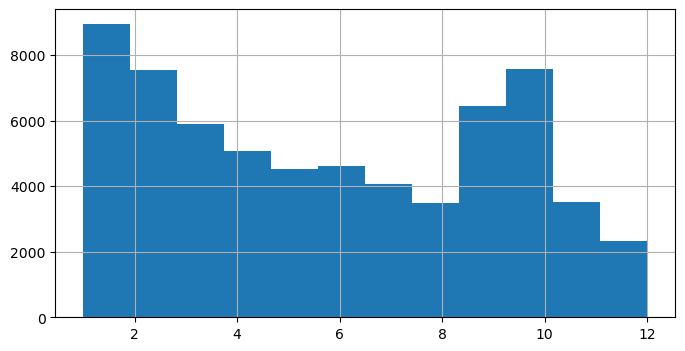

In [6]:
# Визуализируем распределение признака 'recency'
data.loc[:, 'recency'].hist(figsize=(8, 4), bins=12, grid=True)


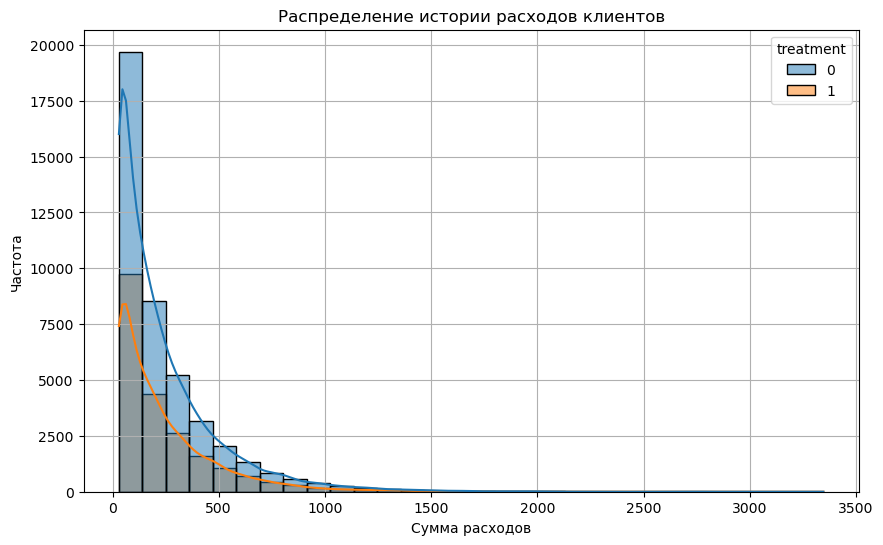

In [7]:
# Визуализируем распределение признака 'history' по группам воздействия
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='history', bins=30, kde=True, hue='treatment')
plt.title('Распределение истории расходов клиентов')
plt.xlabel('Сумма расходов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()



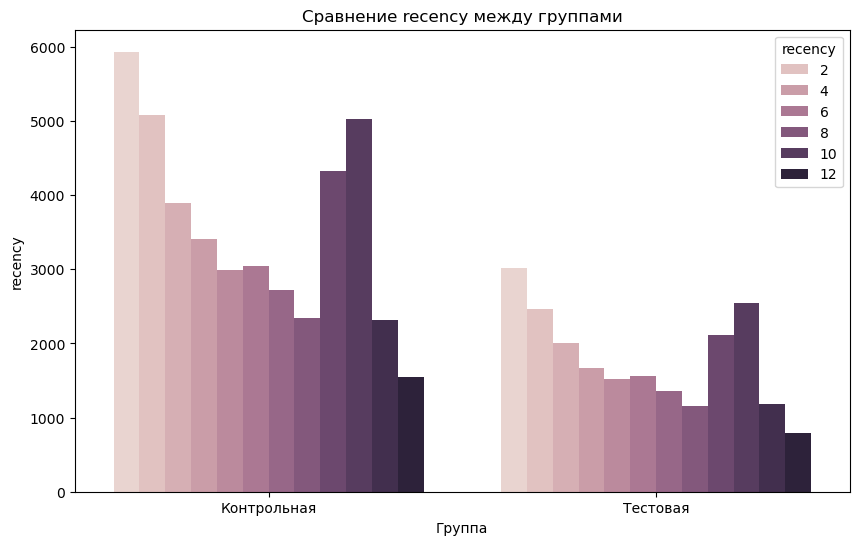

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x ='treatment', hue='recency')
plt.title('Сравнение recency между группами')
plt.xlabel('Группа')
plt.ylabel('recency')
plt.xticks(ticks=[0, 1], labels=['Контрольная', 'Тестовая'])
plt.show()

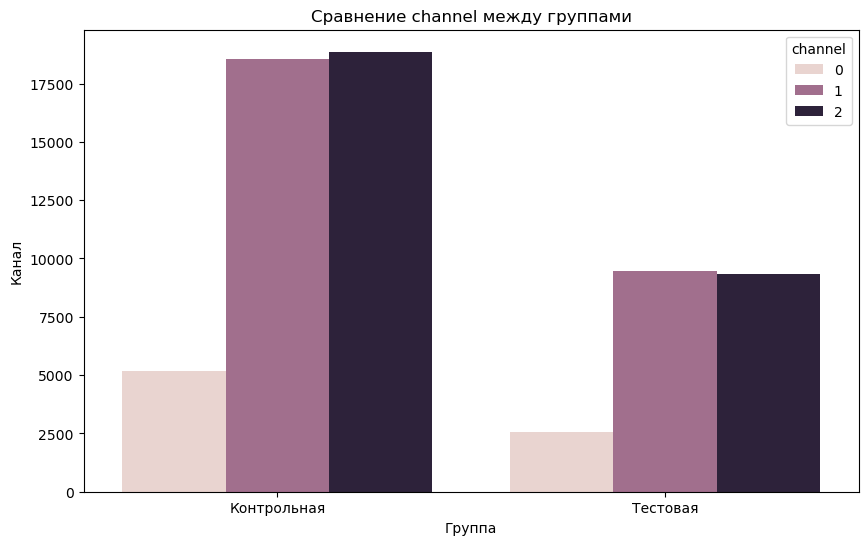

In [9]:
# Визуализируем распределение признака 'channel' по группам воздействия
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x ='treatment', hue='channel')
plt.title('Сравнение channel между группами')
plt.xlabel('Группа')
plt.ylabel('Канал')
plt.xticks(ticks=[0, 1], labels=['Контрольная', 'Тестовая'])
plt.show()

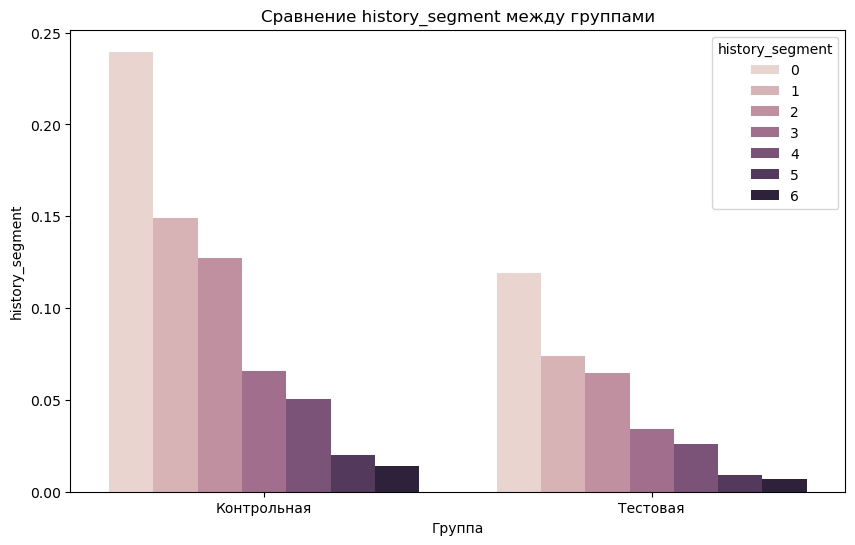

In [10]:
# Визуализируем распределение признака 'history_segment' по группам воздействия
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x ='treatment', hue='history_segment', stat='proportion')
plt.title('Сравнение history_segment между группами')
plt.xlabel('Группа')
plt.ylabel('history_segment')
plt.xticks(ticks=[0, 1], labels=['Контрольная', 'Тестовая'])
plt.show()

 На основе исследовательского анализа данных можно сделать вывод, что:

1. Выборка довольно сильно несбалансирована по воздействию, что может повлиять на результаты анализа и интерпретацию модели. Необходимо учитывать, что несбалансированность может привести к смещению в оценке uplift
1. Доля мужчин в контрольной и тестовой группах примерно равна, что может указывать на отсутствие предвзятости в распределении по полу.
2. Распределение признака `recency` показывает, что большинство клиентов имеют низкие значения, что может свидетельствовать о недавних покупках.
3. Признак `history` демонстрирует разнообразие в расходах клиентов, с заметным количеством клиентов, имеющих высокие расходы в тестовой группе.
4. Анализ канала показывает, что в контрольной группе преобладает мобильный и веб каналы продаж.
5. Форма распределения `history_segment` между контрольной и тестовой группой совпадает, что указывает на отсутствие значительных различий в сегментации клиентов по этому признаку.


# Этап 2

### Проверка на статистическую значимость

Тест Хи-квадрат был выбран, так как он позволяет оценить статистическую значимость различий между двумя или более группами по категориальным данным. В данном случае, мы сравниваем контрольную и тестовую группы по целевой переменной, которая является бинарной (0 или 1) и размер выборки сравнительно больщой.



In [11]:
data_stat = data.copy()

# Создание таблицы сопряженности
contingency_table = pd.crosstab(data_stat['treatment'], data_stat['target'])

# Проведение теста Хи-квадрат
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Вывод результатов
print(f"Хи-квадрат статистика: {chi2_stat.round(2)}, P-значение: {p_value.round(2)}")

# Проверка, меньше ли p-значение уровня значимости (0.05)
if p_value < 0.05:
    print("Разница между контрольной и тестовой группами статистически значима.")
else:
    print("Разница между контрольной и тестовой группами не статистически значима.")


Хи-квадрат статистика: 5.42, P-значение: 0.02
Разница между контрольной и тестовой группами статистически значима.


## Построение корреляций

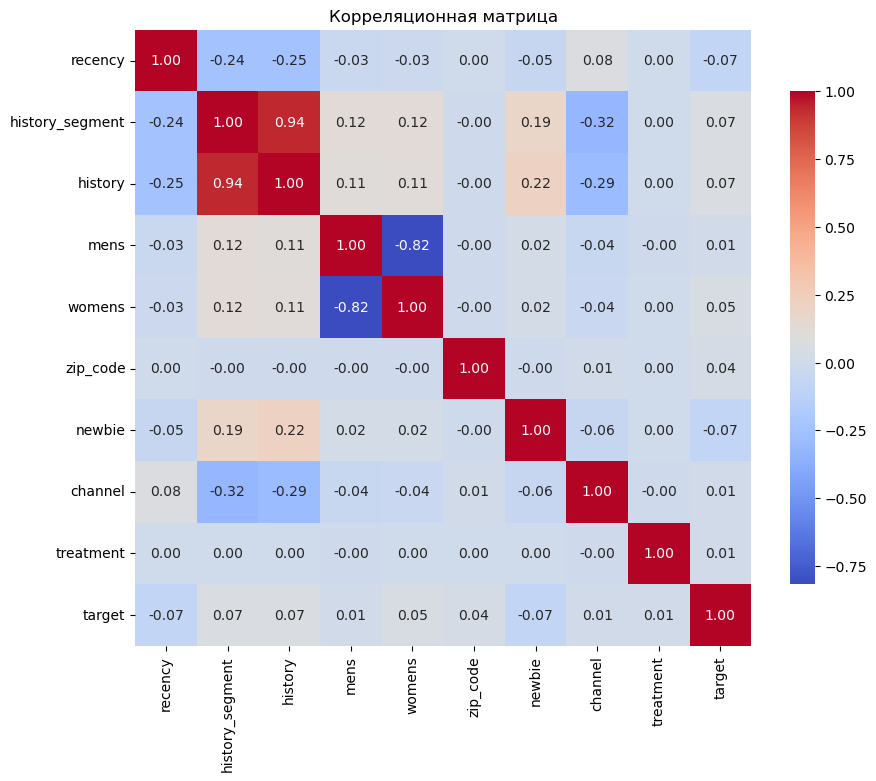

In [12]:

# Вычисление корреляционной матрицы
correlation_matrix = data.corr()

# Построение хитмапа
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица')
plt.show()


Исходя из карты корреляций можно сделать вывод, что признаки не имеют сильной корреляции с целевой переменной, однако существуют довольно сильные отрицательные корреляции между признаками `womens` и `mens`, а также между `channel` и `history_segment`. Отрицательная корреляция между каналом продаж и сегментом истории покупок может указывать на то, что клиенты с определенной историей покупок предпочитают конкретные каналы взаимодействия. Например, клиенты с высокой историей покупок могут предпочитать определенные каналы продаж. Отсутствие мультиколлинеарности между большинством признаков является положительным фактором для построения моделей, так как это снижает риск переобучения и улучшает интерпретируемость результатов.


## Этап 3

Исходя из того, что в датасете 64000 примеров и выборка несбалансирована в сторону отсутствия воздействия, предлагаю использовать алгоритм **X-learner**, так как он позволяет эффективно оценивать влияние воздействия на результаты, даже в условиях несбалансированных данных. Этот метод учитывает как контрольную, так и тестовую группы, что позволяет более точно оценить эффект воздействия и минимизировать смещение в оценках.

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [13]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['treatment', 'target'])
y = data['target']
treatment = data['treatment']

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.3, random_state=42)

X_train.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
9656,7,3,434.35,1,0,0,1,2
63037,1,3,376.59,1,0,1,0,0
31405,3,1,140.34,0,1,0,1,1
58088,3,1,150.76,0,1,1,0,2
44344,2,0,67.97,1,0,1,1,1


### Обучение выбранного бейзлайна

In [14]:
from causalml.inference.meta import BaseXClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score

# используем Random Forest для outcome- и effect-моделей
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=8,
    n_jobs=-1,
    verbose=0
)
rf_reg = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=6,
    n_jobs=-1,
    verbose=0
)

# для propensity score используем XGBoost
propensity_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0
)
propensity_model.fit(X_train.values, treatment_train)
# получаем propensity score для train и test
p_train = propensity_model.predict_proba(X_train.values)[:, 1]
p_test = propensity_model.predict_proba(X_test.values)[:, 1]

x_learner = BaseXClassifier(
    outcome_learner=rf_clf,
    control_name=0,
    effect_learner=rf_reg,
)

# обучаем X-learner с передачей propensity score
x_learner.fit(
    X=X_train.values,
    treatment=treatment_train,
    y=y_train.values,
    p=p_train
)


### Расчет метрик для выбранного бейзлайна на тестовой выборке

In [ ]:

# получаем uplift-предсказания для тестовой выборки, также передаём propensity score
uplift_pred = x_learner.predict(
    X_test.values,
    p=p_test
)

# оценка метрик uplift
uplift_score = uplift_auc_score(
    y_test.values,
    uplift_pred.squeeze(),
    treatment_test
)
qini_score = qini_auc_score(
    y_test.values,
    uplift_pred.squeeze(),
    treatment_test
)
uplift_at30 = uplift_at_k(y_true=y_test, uplift=uplift_pred.squeeze(), strategy='overall', treatment=treatment_test, k=0.3)

print(f'Uplift AUC: {round(uplift_score, 3)}')
print(f'Qini AUC: {round(qini_score, 3)}')
print(f'Uplift at 30%: {round(uplift_at30, 3)}')

Uplift AUC: 0.02
Qini AUC: 0.05
Uplift at 30%: 0.03


# Обучение 2 моделей 

### Обучение модели 1

In [16]:
from causalml.inference.tree import UpliftRandomForestClassifier

# Словарь для отображения значений treatment на названия групп
treatment_mapping = {
    0: 'control',  # контрольная группа
    1: 'treatment'  # группа, получающая воздействие
}

# Применяем отображение к обучающей и тестовой выборкам
treatment_train_mapped = treatment_train.map(treatment_mapping)  # преобразуем значения в обучающей выборке
treatment_test_mapped = treatment_test.map(treatment_mapping)    # преобразуем значения в тестовой выборке

# Инициализация модели UpliftRandomForestClassifier с заданными параметрами
uplift_tree = UpliftRandomForestClassifier(
    control_name='control',  # название контрольной группы
    evaluationFunction='ED',  # функция оценки, используемая для модели
    max_depth=8,             # максимальная глубина деревьев
    n_estimators=200,        # количество деревьев в лесу
    random_state=42          # фиксируем случайное состояние для воспроизводимости
)

# Обучение модели на обучающей выборке
uplift_tree.fit(
    X_train.values,                # признаки обучающей выборки
    treatment_train_mapped.values,  # преобразованные значения treatment для обучающей выборки
    y_train.values                  # целевая переменная
)


Failed to import duecredit due to No module named 'duecredit'


### Получение метрик по модели 1

In [ ]:
# Получаем предсказания uplift от модели на тестовой выборке
uplift_pred = uplift_tree.predict(X_test.values, full_output=False).squeeze()

# Вычисляем метрику uplift AUC для оценки качества модели
uplift_score = uplift_auc_score(y_test.values, uplift_pred, treatment_test)

# Вычисляем Qini AUC для оценки эффективности модели
qini_score = qini_auc_score(y_test.values, uplift_pred, treatment_test)

# Вычисляем uplift на уровне 30% для анализа воздействия
uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')

# Выводим результаты 
print(f'Uplift AUC: {round(uplift_score, 3)}')
print(f'Qini AUC: {round(qini_score, 3)}')
print(f'Uplift at 30%: {round(uplift_at_30, 3)}')

Uplift AUC: 0.02
Qini AUC: 0.04
Uplift at 30%: 0.04


### Обучение модели 2

In [18]:
from causalml.inference.meta import BaseTClassifier

# создаём базовые модели для тестовой и контрольной групп 
treatment_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

control_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

# инициализируем T-learner
t_learner = BaseTClassifier(
    treatment_learner=treatment_model,
    control_learner=control_model,
    control_name=0,  # название контрольной группы в столбце treatment
)

# обучаем T-learner
# примечание: X_train должен иметь столбец treatment со значениями treatment и control
t_learner.fit(
    X=X_train.values,  
    treatment=treatment_train.values,       # Столбец с признаком воздействия
    y=y_train.values                            # Целевая переменная
)


### Получение метрик по модели 2

In [ ]:

# получаем предсказания для тестовой выборки
uplift_pred = t_learner.predict(X_test.values).squeeze()

# рассчитываем метрики uplift
uplift_score = uplift_auc_score(
    y_test.values, 
    uplift_pred, 
    treatment_test
)
qini_score = qini_auc_score(
    y_test.values, 
    uplift_pred, 
    treatment_test.values
)

# Вычисляем uplift на уровне 30% для анализа воздействия
uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')

# Выводим результаты 
print(f'Uplift AUC: {round(uplift_score, 3)}')
print(f'Qini AUC: {round(qini_score, 3)}')
print(f'Uplift at 30%: {round(uplift_at_30, 3)}')

Uplift AUC: 0.02
Qini AUC: 0.05
Uplift at 30%: 0.04


 
Вывод о выборе модели:
 
Рекомендую использовать T-Learner по следующим причинам:
 
 1. Лучшая качество по Qini AUC: T-Learner показывает значение 0.05, что равно результату X-Learner, но лучше, чем UpliftRandomForestClassifier (0.04). Qini AUC является важной метрикой для uplift-моделей, так как она оценивает способность модели ранжировать клиентов по их потенциальному uplift.
 
2. Хороший баланс метрик: T-Learner демонстрирует стабильные результаты по всем трем метрикам, что указывает на его надежность.
 
3. Интерпретируемость: T-Learner обучает отдельные модели для контрольной и тестовой групп, что делает его более интерпретируемым по сравнению с X-Learner.
 

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

In [25]:
from catboost import CatBoostClassifier

## Генерация признаков

In [71]:
X = data.drop(columns=['treatment', 'target'])
y = data['target']
treatment = data['treatment']

# Создаем новые признаки на основе существующих
X['recency_squared'] = X['recency'] ** 2  # Квадрат recency для учета нелинейных эффектов
X['history_segment_log'] = np.log1p(X['history_segment'])  # Логарифм history_segment для нормализации
X['history_ratio'] = X['history'] / (X['recency'] + 1)  # Отношение history к recency для оценки активности
X['total_spent'] = X['history'] * (X['mens'] + X['womens'])  # Общая сумма потраченных средств

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.3, random_state=42)

X_train.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,recency_squared,history_segment_log,history_ratio,total_spent
9656,7,3,434.35,1,0,0,1,2,49,1.386294,54.293750,434.35
63037,1,3,376.59,1,0,1,0,0,1,1.386294,188.295000,376.59
31405,3,1,140.34,0,1,0,1,1,9,0.693147,35.085000,140.34
58088,3,1,150.76,0,1,1,0,2,9,0.693147,37.690000,150.76
44344,2,0,67.97,1,0,1,1,1,4,0.000000,22.656667,67.97


In [39]:
import optuna
from optuna import create_study

def objective(trial):
    # создаём базовые модели для тестовой и контрольной групп 
    treatment_model = CatBoostClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=trial.suggest_float('treatment_learning_rate', 0.01, 0.1, step=0.01),
        subsample=trial.suggest_float('treatment_subsample', 0.5, 1.0, step=0.1),
        l2_leaf_reg=trial.suggest_float('treatment_l2_leaf_reg', 0.01, 1.0, step=0.01),
        verbose=False,
        random_state=42
    )

    control_model = CatBoostClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=trial.suggest_float('control_learning_rate', 0.01, 0.1, step=0.01),
        subsample=trial.suggest_float('control_subsample', 0.5, 1.0, step=0.1),
        l2_leaf_reg=trial.suggest_float('control_l2_leaf_reg', 0.01, 1.0, step=0.01),
        verbose=False,
        random_state=42
    )

    # инициализируем T-learner
    t_learner = BaseTClassifier(
        treatment_learner=treatment_model,
        control_learner=control_model,
        control_name=0,  # название контрольной группы в столбце treatment
    )

    # обучаем T-learner
    # примечание: X_train должен иметь столбец treatment со значениями treatment и control
    t_learner.fit(
        X=X_train.values,  
        treatment=treatment_train.values,       # Столбец с признаком воздействия
        y=y_train.values                            # Целевая переменная
    )

    # Предсказания
    uplift_pred = t_learner.predict(X_test).squeeze()

    # Рассчитываем метрики uplift
    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
    return uplift_at_30

# Создаем и запускаем исследование
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


[I 2025-06-26 15:03:28,741] A new study created in memory with name: no-name-43d62158-617f-4e7a-998f-2d81d2719fa0
[I 2025-06-26 15:03:30,774] Trial 0 finished with value: 0.04708667997460256 and parameters: {'treatment_learning_rate': 0.05, 'treatment_subsample': 0.9, 'treatment_l2_leaf_reg': 0.68, 'control_learning_rate': 0.04, 'control_subsample': 0.9, 'control_l2_leaf_reg': 0.04}. Best is trial 0 with value: 0.04708667997460256.
[I 2025-06-26 15:03:32,603] Trial 1 finished with value: 0.03867317902710746 and parameters: {'treatment_learning_rate': 0.04, 'treatment_subsample': 0.5, 'treatment_l2_leaf_reg': 0.55, 'control_learning_rate': 0.01, 'control_subsample': 0.7, 'control_l2_leaf_reg': 0.9600000000000001}. Best is trial 0 with value: 0.04708667997460256.
[I 2025-06-26 15:03:34,595] Trial 2 finished with value: 0.04681129248006116 and parameters: {'treatment_learning_rate': 0.09999999999999999, 'treatment_subsample': 0.7, 'treatment_l2_leaf_reg': 0.09, 'control_learning_rate': 0.

Best hyperparameters:  {'treatment_learning_rate': 0.04, 'treatment_subsample': 0.7, 'treatment_l2_leaf_reg': 0.49, 'control_learning_rate': 0.03, 'control_subsample': 1.0, 'control_l2_leaf_reg': 0.5}
Best score:  0.051976369495166486


## Этап 2

### Визуализация результатов

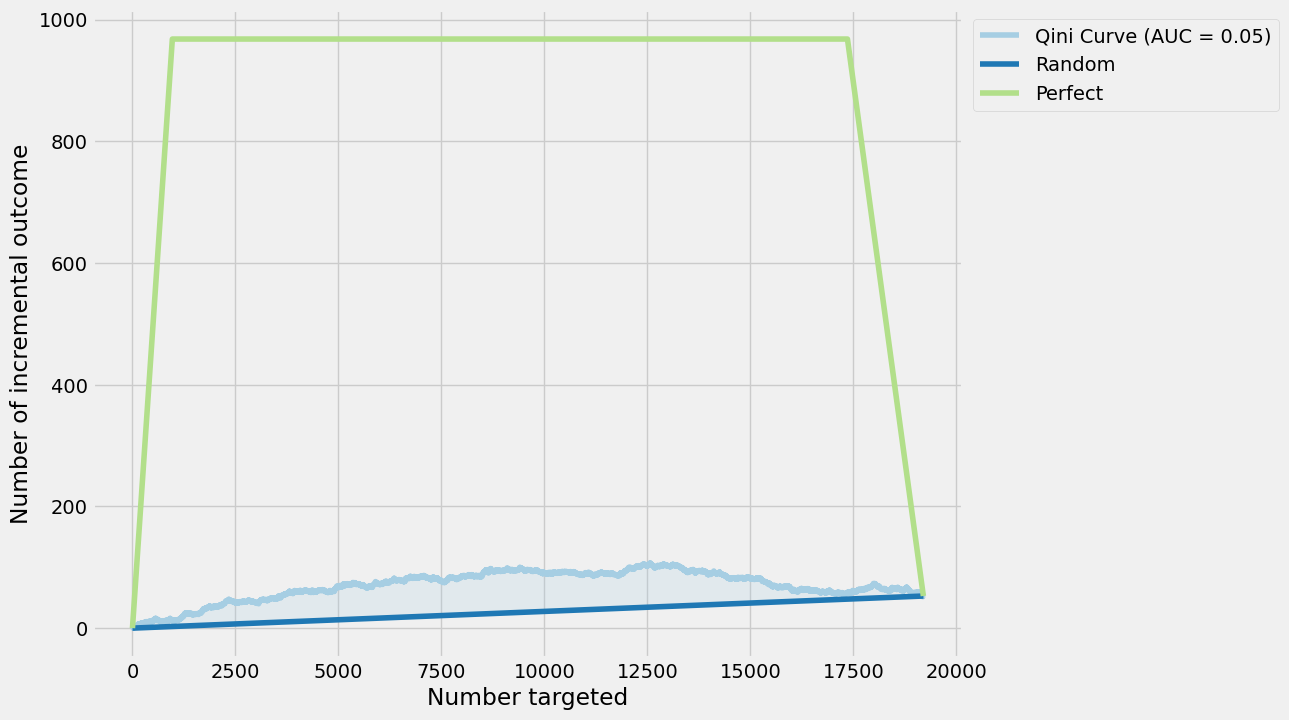

In [48]:
from sklift.viz import plot_qini_curve, plot_uplift_curve
from utils import custom_uplift_by_percentile

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
plot_qini_curve(y_test, uplift_pred, treatment_test, perfect=True, ax=axs,
                  name='Qini Curve')


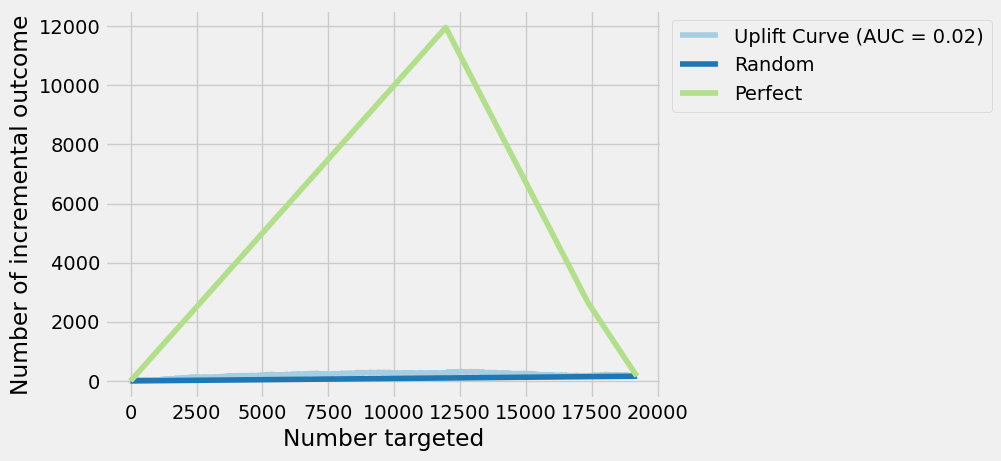

In [49]:
plot_uplift_curve(y_test, uplift_pred, treatment_test
                  ,name='Uplift Curve')


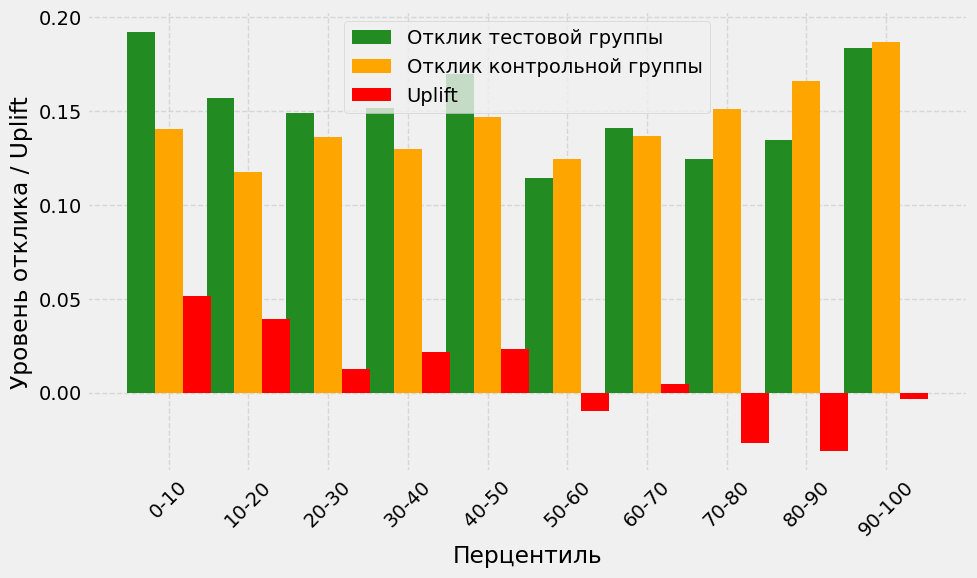

In [53]:
fig = custom_uplift_by_percentile(y_test, uplift_pred, treatment_test, kind='bar')

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [138]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
        X['recency_squared'] = X['recency'] ** 2  # Квадрат recency для учета нелинейных эффектов
        X['history_segment_log'] = np.log1p(X['history_segment'])  # Логарифм history_segment для нормализации
        X['history_ratio'] = X['history'] / (X['recency'] + 1)  # Отношение history к recency для оценки активности
        X['total_spent'] = X['history'] * (X['mens'] + X['womens'])  # Общая сумма потраченных средств

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        uplift = self.model.predict(X).squeeze()
        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [126]:
model = UpliftModelInference(model=t_learner, feature_names=list(X_train.columns))

In [137]:
import unittest

class TestUpliftModelInference(unittest.TestCase):

    @classmethod
    def setUp(self):
        """Создаем тестовые данные и экземпляр класса перед каждым тестом"""
       
        
        # Создаем тестовые данные
        self.test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })
        
      
                
        self.model = t_learner
        self.feature_names = list(X_train.columns)
        self.uplift_model = UpliftModelInference(self.model, self.feature_names)

    def test_correct_prediction_shape(self):
        """Проверяем, что размерность предсказаний корректная"""
        predictions = self.uplift_model.predict(self.test_data)
        self.assertEqual(len(predictions), len(self.test_data))

    def test_missing_features(self):
        """Проверяем обработку отсутствующих признаков"""
        # Удаляем один из признаков
        incomplete_data = self.test_data.drop('recency', axis=1)
        predictions = self.uplift_model.predict(incomplete_data)
 
        self.assertIsNone(predictions[0], None)

    def test_empty_data(self):
        """Проверяем обработку пустого датафрейма"""
        empty_data = pd.DataFrame(columns=self.feature_names)
        predictions = self.uplift_model.predict(empty_data)
        self.assertIsNone(predictions)

    def test_prediction_type(self):
        """Проверяем тип возвращаемых предсказаний"""
        predictions = self.uplift_model.predict(self.test_data)
        
        self.assertIsInstance(predictions, np.ndarray)

  

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


/opt/anaconda3/envs/uplift_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/uplift_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
.../opt/anaconda3/envs/uplift_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/uplift_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
.
----------------------------------------------------------------------
Ran 4 tests in 0.055s

OK
